# CMPT 310: Project

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

print("no issue")

no issue


### Data Preprocessing

In [12]:
df_GDMPBC = pd.read_csv('Data/bcea_GDMPBC.csv', header=None)
df_GDMPBC = df_GDMPBC.transpose()

df_GDMPBC.columns = ['YEAR', 'GDMPBC']

print(df_GDMPBC.head())
df_GDMPBC.to_csv('Data/edited data/bcea_GDMPBC_RW.csv', index=False)

   YEAR  GDMPBC
0  1981  40,546
1  1982  37,291
2  1983  37,164
3  1984  36,997
4  1985  39,233


In [13]:
df_Unemployment = pd.read_csv('Data/Unemployment.csv', header=None)
df_Unemployment = df_Unemployment.transpose()

df_Unemployment.columns = df_Unemployment.iloc[0]
df_Unemployment = df_Unemployment[1:]
df_Unemployment.rename(columns={'Educational attainment 7': 'YEAR'}, inplace=True)

print(df_Unemployment.iloc[0])
df_Unemployment.to_csv('Data/edited data/Unemployment_RW.csv', index=False)

0
YEAR                                       1990.0
Total, all education levels                   7.4
0 to 8  years 8                              10.5
Some high school 9                           12.9
High school graduate 10                       6.7
Some postsecondary 11                         8.8
Postsecondary certificate or diploma 12       6.2
University degree 13                          4.3
Bachelor's degree                             4.6
Above bachelor's degree                       3.9
Name: 1, dtype: object


In [14]:
df_CPI = pd.read_csv('Data/CPI.csv', header=None)

df_CPI.columns = df_CPI.iloc[0]
df_CPI = df_CPI[1:]
df_CPI.rename(columns={'Year': 'YEAR'}, inplace=True)

print(df_CPI.head())
df_CPI.to_csv('Data/edited data/CPI_RW.csv', index=False)

0  YEAR All Items Index Annual Percent Change
1  1980            45.4                   9.4
2  1981            51.8                  14.1
3  1982            57.3                  10.6
4  1983            60.4                   5.4
5  1984            62.8                     4


In [15]:
df_Housing = pd.read_csv('Data/Housing.csv', header=None)

df_Housing.columns = df_Housing.iloc[0]
df_Housing = df_Housing[1:]

print(df_Housing.iloc[0])
df_Housing.to_csv('Data/edited data/Housing_RW.csv', index=False)

0
YEAR                                                       1979
QUARTER                                                       1
HOUSING TYPE                                    Single-detached
MEDIAN HOUSING PRICE                                      56000
MEDIAN AFTER TAX FAMILY INCOME                      21211.09838
PRIME INTEREST RATE                                 11.96153846
QUARTERLY PAYMENT                                   1638.624101
PAYMENT TO INCOME PERCENT                            30.9012588
HISTORICAL AVERAGE PAYMENT TO INCOME PERCENT        42.17672164
NUMBER OF RESALES                                          2598
Name: 1, dtype: object


In [16]:
# combine data

df_Unemployment["YEAR"] = df_Unemployment["YEAR"].astype(int) # remove the decimal point
df_Unemployment["YEAR"] = df_Unemployment["YEAR"].astype(str)
df_merged = (
    df_GDMPBC
    .merge(df_Unemployment, on='YEAR')
    .merge(df_CPI, on='YEAR')
    .merge(df_Housing, on='YEAR')
)

df_merged = df_merged.applymap(lambda x: x.replace(",", "") if isinstance(x, str) else x)
df_merged = df_merged.applymap(lambda a: np.nan if a == "x" else a)

housing_type = {"Single-detached":0, "Apartment":1, "Row housing":2, "All housing types":3}
df_merged["HOUSING TYPE"] = df_merged["HOUSING TYPE"].map(housing_type)
df_merged = df_merged.astype(float)

print(df_merged.iloc[0])
df_merged.to_csv('Data/edited data/merged_data.csv', index=False)

YEAR                                              1990.000000
GDMPBC                                           41964.000000
Total, all education levels                          7.400000
0 to 8  years 8                                     10.500000
Some high school 9                                  12.900000
High school graduate 10                              6.700000
Some postsecondary 11                                8.800000
Postsecondary certificate or diploma 12              6.200000
University degree 13                                 4.300000
Bachelor's degree                                    4.600000
Above bachelor's degree                              3.900000
All Items Index                                     78.400000
Annual Percent Change                                5.400000
QUARTER                                              1.000000
HOUSING TYPE                                         0.000000
MEDIAN HOUSING PRICE                            158900.000000
MEDIAN A

C:\Users\ngzix\AppData\Local\Temp\ipykernel_31548\431976995.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_merged = df_merged.applymap(lambda x: x.replace(",", "") if isinstance(x, str) else x)
C:\Users\ngzix\AppData\Local\Temp\ipykernel_31548\431976995.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_merged = df_merged.applymap(lambda a: np.nan if a == "x" else a)


In [42]:
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.metrics import mean_squared_error, r2_score

# Read CSV file
df_merged = pd.read_csv('Data/edited data/merged_data.csv')

# for simplicity, just keep one housing type (all housing types)
df = df_merged[df_merged['HOUSING TYPE'] == 3]
df = df.drop(columns=['HOUSING TYPE'])
df = df.dropna()

# merge year and quarter into a single feature (doing this lowered r2 score :/)
df['YEAR'] = df['YEAR'] + (df['QUARTER'] - 1) * 0.25
df = df.drop(columns=['QUARTER'])

# Create target = price change (ΔPrice), we will be predicting this instead
# df['PRICE CHANGE'] = df['MEDIAN HOUSING PRICE'].diff()
df['PRICE CHANGE PCT'] = df['MEDIAN HOUSING PRICE'].pct_change()
df.dropna(inplace=True) # Drop rows with NaN values


# lets try to predict housing price for years > 2018
df_train = df[df['YEAR'] <= 2018]
df_test = df[df['YEAR'] > 2018]

DT_model = DecisionTreeRegressor(max_depth=4, random_state=42)
X_train = df_train.drop(columns=['MEDIAN HOUSING PRICE', 'PRICE CHANGE PCT'])
y_train = df_train['PRICE CHANGE PCT']
DT_model.fit(X_train, y_train)

y_pred = DT_model.predict(df_test.drop(columns=['MEDIAN HOUSING PRICE', 'PRICE CHANGE PCT'])) # Predict change in prices

In [43]:
# Evaluating based on percentage change predictions
mse = mean_squared_error(df_test['PRICE CHANGE PCT'], y_pred)
r2 = r2_score(df_test['PRICE CHANGE PCT'], y_pred)
print(f'Mean Squared Error: {mse:.2f}, Sqrt MSE: {np.sqrt(mse):.2f}')
print(f'R^2 Score: {r2:.2f}')

Mean Squared Error: 0.00, Sqrt MSE: 0.04
R^2 Score: -1.33


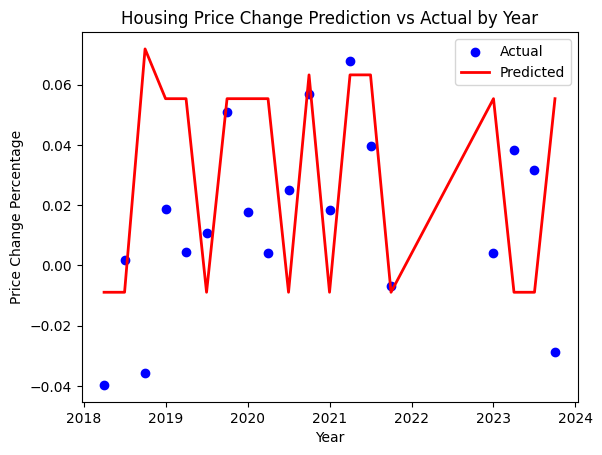

In [44]:
import matplotlib.pyplot as plt

# plot for percentage change actual values & predicted values
plt.scatter(df_test['YEAR'], df_test['PRICE CHANGE PCT'], color='blue', label='Actual')
plt.plot(df_test['YEAR'], y_pred, color='red', linewidth=2, label='Predicted')

plt.xlabel('Year')
plt.ylabel('Price Change Percentage')
plt.title('Housing Price Change Prediction vs Actual by Year')
plt.legend()
plt.show()

In [45]:
# Evaluating based on actual price predictions
# Get Actual predicted prices from predicted price changes
last_known_price = df_train.iloc[-1]['MEDIAN HOUSING PRICE']
price_predict = []
current_price = last_known_price

for pct in y_pred:
    current_price *= (1 + pct)
    price_predict.append(current_price)

mse = mean_squared_error(df_test['MEDIAN HOUSING PRICE'], price_predict)
r2 = r2_score(df_test['MEDIAN HOUSING PRICE'], price_predict)
print(f'Mean Squared Error: {mse:.2f}, Sqrt MSE: {np.sqrt(mse):.2f}')
print(f'R^2 Score: {r2:.2f}')

Mean Squared Error: 28110771319.29, Sqrt MSE: 167662.67
R^2 Score: -3.00


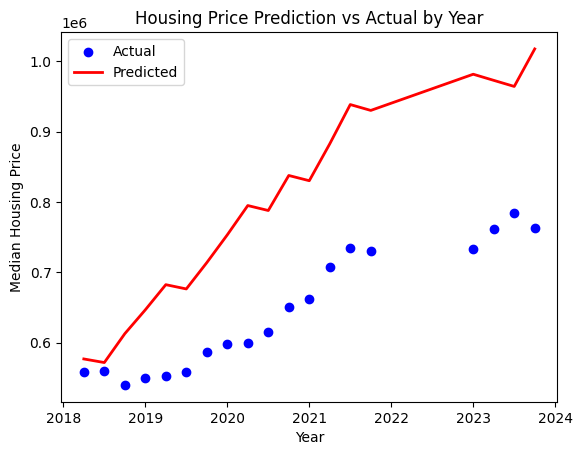

In [46]:
import matplotlib.pyplot as plt

# plot for actual values & predicted values
plt.scatter(df_test['YEAR'], df_test['MEDIAN HOUSING PRICE'], color='blue', label='Actual')
plt.plot(df_test['YEAR'], price_predict, color='red', linewidth=2, label='Predicted')

plt.xlabel('Year')
plt.ylabel('Median Housing Price')
plt.title('Housing Price Prediction vs Actual by Year')
plt.legend()
plt.show()

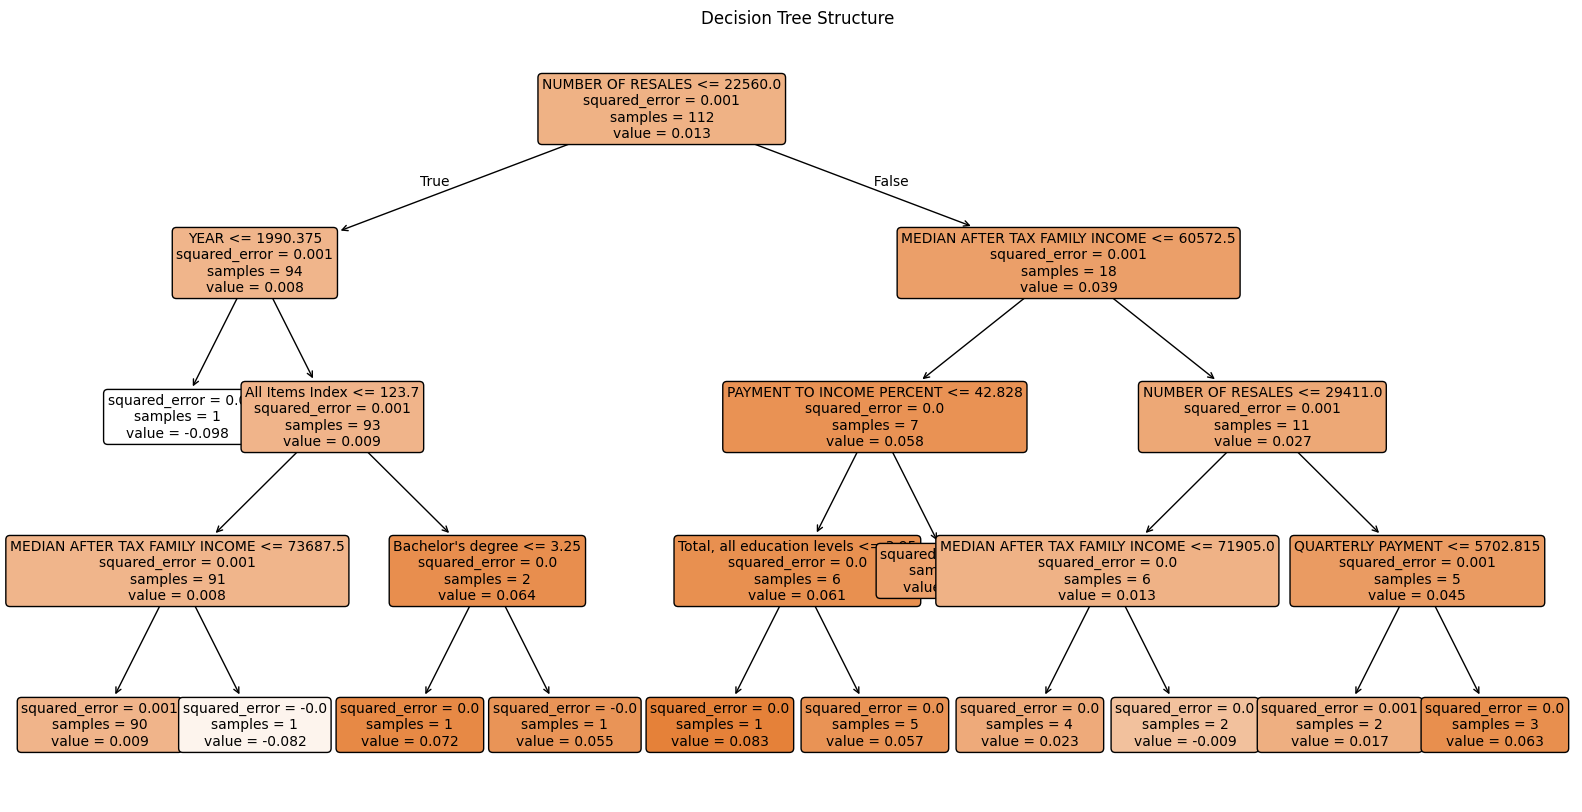

In [47]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(
    DT_model,
    feature_names=X_train.columns,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Structure")
plt.show()